<a href="https://colab.research.google.com/github/mariagomeess/dataset-c-ncer-de-mama-ml/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Aplicado à Saúde: Predição de Câncer de Mama**

Desenvolver uma aplicação prática e interativa utilizando **Python** e **Streamlit** que demonstre o uso de **técnicas de aprendizagem supervisionada e não supervisionada** para a **análise e predição do câncer de mama**.

O principal propósito é construir um modelo capaz de **classificar tumores mamários como malignos ou benignos**, compreender **quais fatores mais influenciam o diagnóstico**, e **explorar agrupamentos de pacientes** com características semelhantes.

---

O câncer de mama é um dos tipos mais incidentes no mundo e uma das principais causas de morte entre mulheres.  
O diagnóstico precoce é essencial para o sucesso do tratamento, e métodos de apoio baseados em **inteligência artificial** vêm se tornando ferramentas cada vez mais relevantes na prática médica.

Neste projeto, é utilizado o **Breast Cancer Wisconsin Dataset**, um dos conjuntos de dados mais conhecidos da área médica, disponível na biblioteca **Scikit-learn** (`load_breast_cancer()`).

O dataset reúne **569 amostras clínicas**, contendo **30 atributos** que descrevem características físicas das células mamárias, obtidas por meio de imagens digitalizadas de tecidos.  

Entre as principais variáveis estão:
- `mean radius`: tamanho médio do núcleo celular  
- `mean texture`: variação de textura entre as células  
- `mean area`: área média das células  
- `mean smoothness`: suavidade das bordas celulares  
- `mean concavity`: grau de concavidade observado  

A variável alvo (`target`) representa o diagnóstico:
- `M` → **Malignant (Maligno)**  
- `B` → **Benign (Benigno)**

---

O estudo busca responder às seguintes perguntas-chave:

- Quais características celulares estão mais associadas à malignidade de um tumor?  
- É possível construir um modelo que **prediga com alta precisão** o diagnóstico de novos pacientes?  
- Quais **padrões ou agrupamentos** podem ser identificados entre os diferentes tipos de tumores?  
- Como garantir que o modelo seja **ético, transparente e reprodutível**, respeitando os princípios da LGPD?

---

**Conjunto de dados:** 569 amostras, 30 características, 2 classes (357 benignas, 212 malignas)



1. Configuração e importação

Instalação de bibliotecas essenciais para análise de dados, visualização e aprendizado de máquina.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
)

#Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Deep Learning
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, callbacks
    KERAS_AVAILABLE = True
    print(f"✓ TensorFlow {tf.__version__} available")
except:
    KERAS_AVAILABLE = False
    print("✗ TensorFlow not available - using sklearn models only")
    # TensorFlow importado apenas para possíveis experimentos com redes neurais, não utilizado na versão final do modelo

#XGBoost & LightGBM
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except:
    XGBOOST_AVAILABLE = False
    print("✗ XGBoost not available")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✓ LightGBM available")
except:
    LIGHTGBM_AVAILABLE = False
    print("✗ LightGBM not available")

#SHAP (Explainability)
try:
    import shap
    SHAP_AVAILABLE = True
    print("✓ SHAP available")
except:
    SHAP_AVAILABLE = False
    print("✗ SHAP not available")

#Reprodutibilidade e estilo dos gráficos
SEED = 42
np.random.seed(SEED)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("BREAST CANCER PREDICTION - COMPLETE Setup")

✓ TensorFlow 2.19.0 available
✓ XGBoost available
✓ LightGBM available
✓ SHAP available
BREAST CANCER PREDICTION - COMPLETE Setup


2. Carregamento de dados

Carregando o conjunto de dados do câncer de mama com 30 características numéricas que descrevem as características dos núcleos celulares.

Alvo:

M = Maligno (Câncer)

B = Benigno (Não Canceroso)



In [ ]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

#Criar DataFrame com as features
df = pd.DataFrame(data.data, columns=data.feature_names)

#Adicionar coluna alvo (diagnóstico)
df['target'] = data.target
df['target'] = df['target'].map({0: 'malignant', 1: 'benign'})

#Informações iniciais
print("✓ Dataset loaded successfully!")
print(f"Format: {df.shape}")
print(f"Columns: {df.columns.tolist()[:5]}... (showing top 5)")

✓ Dataset loaded successfully!
Format: (569, 31)
Columns: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']... (showing top 5)


 3. Análise Exploratória de Dados (EDA)

Principais conclusões:

✅ Sem valores faltantes

✅ 63% Benigno, 37% Maligno (ligeiramente desequilibrado, mas administrável)

✅ Fortes correlações entre recursos relacionados ao tamanho

✅ Tumores malignos apresentam valores mais elevados na maioria das características


**Visualizações:**



1.   Distribuição alvo

2.   Mapa de calor de correlações de recursos

3.   Distribuições de recursos por diagnóstico

4.   Detecção de valores discrepantes






In [ ]:
#Informações gerais sobre o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
#Tipos de dados
print(df.dtypes)

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [ ]:
#Exibir as 5 primeiras linhas
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [ ]:
#Estatísticas das variáveis numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [ ]:
#Valores ausentes
df.isnull().sum()

,0
mean radius,0
mean texture,0
mean perimeter,0
mean area,0
mean smoothness,0
mean compactness,0
mean concavity,0
mean concave points,0
mean symmetry,0
mean fractal dimension,0


In [ ]:
#Distribuição do alvo (target)
print("\nTarget Distribution:")
print("-" * 50)
print(df['target'].value_counts())
print(f"\nClass distribution:")
print(df['target'].value_counts(normalize=True))



Target Distribution:
--------------------------------------------------
target
benign       357
malignant    212
Name: count, dtype: int64

Class distribution:
target
benign       0.627417
malignant    0.372583
Name: proportion, dtype: float64



✓ Visualizations saved as 'eda_visualizations.png'


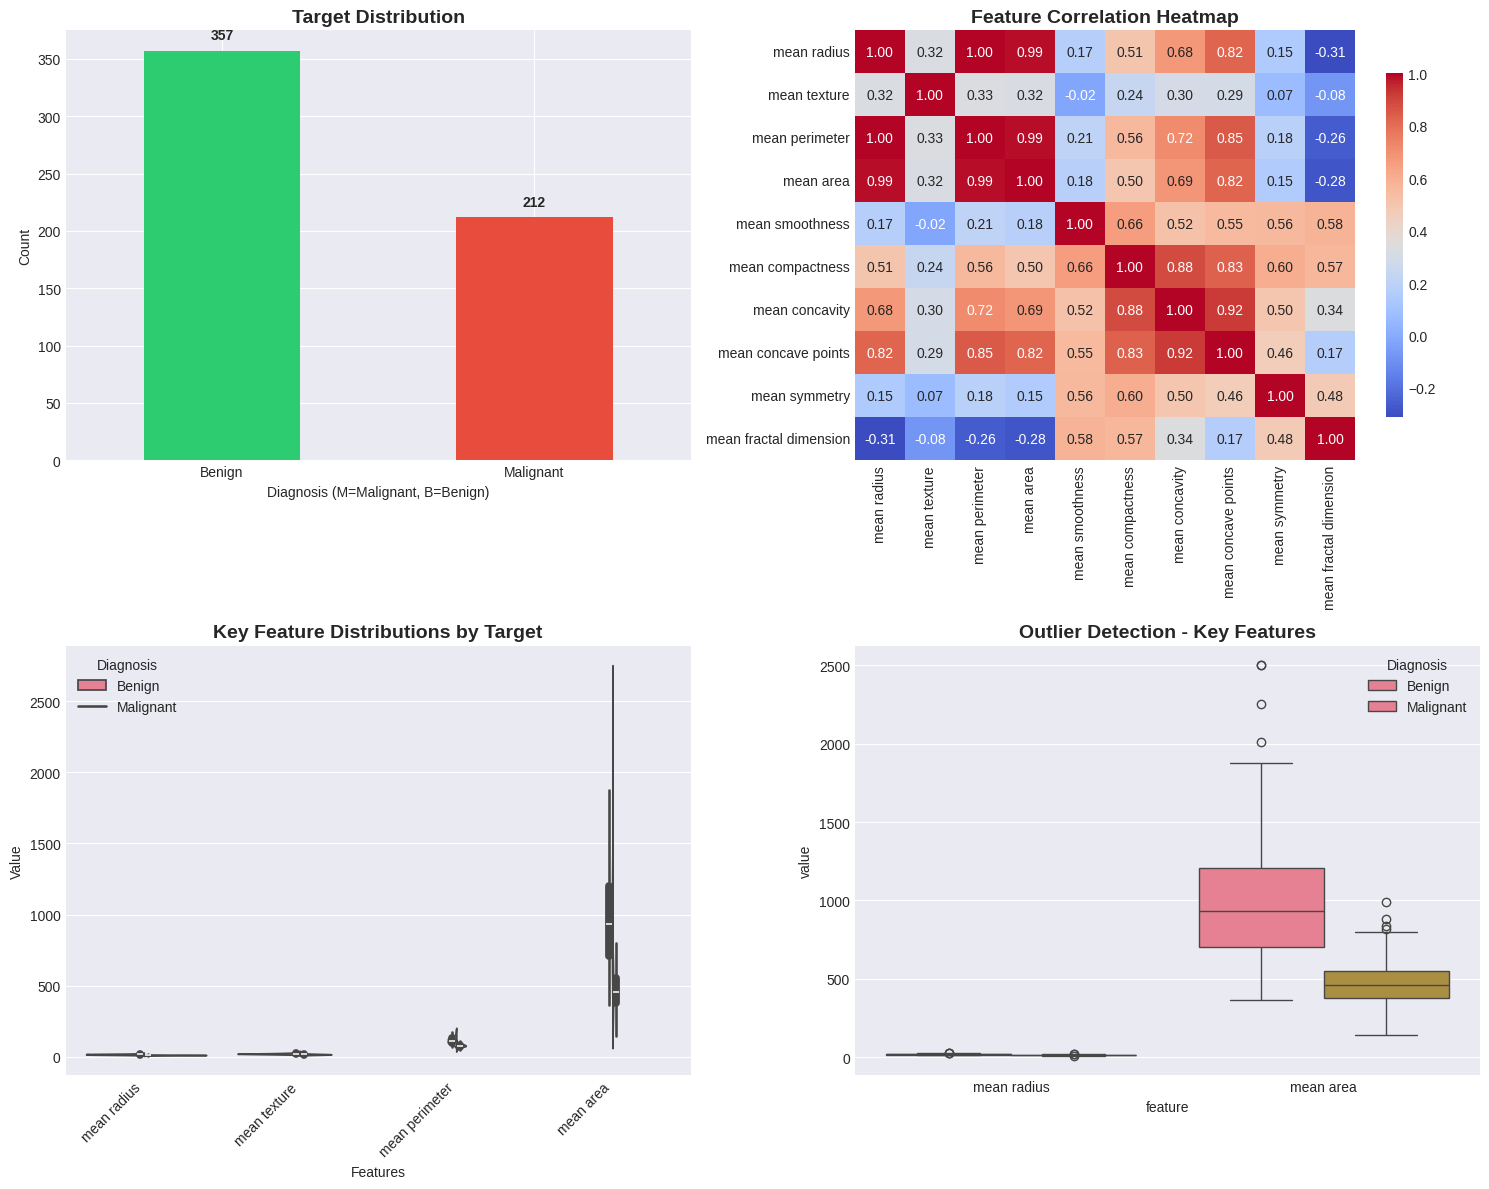

In [ ]:
# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#1. Distribuição da variável alvo (Benign x Malignant)
ax1 = axes[0, 0]
df['target'].value_counts().plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Target Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Diagnosis (M=Malignant, B=Benign)')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Benign', 'Malignant'], rotation=0)

#Adicionar rótulos nos valores
for i, v in enumerate(df['target'].value_counts().values):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

#2. Mapa de correlação das principais variáveis
ax2 = axes[0, 1]
numeric_cols = df.select_dtypes(include=[np.number]).columns[:10]
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')

#3. Distribuição de variáveis importantes por tipo de tumor
ax3 = axes[1, 0]
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']

if all(col in df.columns for col in key_features):
    df_melted = pd.melt(df, id_vars=['target'], value_vars=key_features)
    sns.violinplot(data=df_melted, x='variable', y='value', hue='target', ax=ax3, split=True)
    ax3.set_title('Key Feature Distributions by Target', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Features')
    ax3.set_ylabel('Value')
    ax3.legend(title='Diagnosis', labels=['Benign', 'Malignant'])
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

#4. Detecção de Outliers (Boxplot)
ax4 = axes[1, 1]
if 'mean radius' in df.columns and 'mean area' in df.columns:
    df_box = df[['target', 'mean radius', 'mean area']].copy()
    df_box_melted = pd.melt(df_box, id_vars=['target'], var_name='feature', value_name='value')
    sns.boxplot(data=df_box_melted, x='feature', y='value', hue='target', ax=ax4)
    ax4.set_title('Outlier Detection - Key Features', fontsize=14, fontweight='bold')
    ax4.legend(title='Diagnosis', labels=['Benign', 'Malignant'])

#Finalização
plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualizations saved as 'eda_visualizations.png'")
plt.show()


4. Pré-processamento de dados

**Passos:**



1.   Descartar colunas desnecessárias (id, Unnamed: 32)

2.   Codificar alvo: M→1, B→0

3.   Dados divididos: 80% treino (455), 20% teste (114)

4.   Dimensionar recursos usando o StandardScaler






**Por que escalar?** Garante que todos os recursos contribuam igualmente para os algoritmos de ML.



In [ ]:
#DATA PRE-PROCESSING
#Copiar o DataFrame original
df_clean = df.copy()

#1. Codificação da variável alvo
cols_to_drop = ['id']
if 'Unnamed: 32' in df_clean.columns:
    cols_to_drop.append('Unnamed: 32')

df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns], errors='ignore')
print(f"\n1. Dropped columns: {cols_to_drop}")

#2. Separar features (X) e alvo (y)
print("\n2. Encoding target variable...")
le = LabelEncoder()
df_clean['target'] = le.fit_transform(df_clean['target'])
print(f"   Encoding: malignant = 0, benign = 1")
print(f"   Classes: {le.classes_}")

#3. Verificação e tratamento de valores ausentes
X = df_clean.drop('target', axis=1)
y = df_clean['target']

print(f"\n3. Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Feature names: {X.columns.tolist()[:5]}... (showing first 5)")

#4. Divisão em treino e teste
if X.isnull().sum().sum() > 0:
    print("\n4. Handling missing values...")
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    print("   ✓ Missing values imputed with mean")
else:
    print("\n4. ✓ No missing values to handle")

#5. Normalização (StandardScaler)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\n5. Data split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Testing set: {X_test.shape[0]} samples")
print(f"   Train class distribution: {np.bincount(y_train)}")
print(f"   Test class distribution: {np.bincount(y_test)}")

#6. Dimensionamento de recursos
print("\n6. Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("   ✓ Features scaled using StandardScaler")

#Converter novamente para DataFrame (para facilitar o manuseio)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)



1. Dropped columns: ['id']

2. Encoding target variable...
   Encoding: malignant = 0, benign = 1
   Classes: ['benign' 'malignant']

3. Features shape: (569, 30)
   Target shape: (569,)
   Feature names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']... (showing first 5)

4. ✓ No missing values to handle

5. Data split:
   Training set: 455 samples
   Testing set: 114 samples
   Train class distribution: [285 170]
   Test class distribution: [72 42]

6. Scaling features...
   ✓ Features scaled using StandardScaler


5. Engenharia de recursos

Foram **criados 3 novos recursos** para melhores previsões:



1.   radius_area_ratio - Irregularidade de forma

2.   perimeter_area_ratio – Complexidade do limite

3.   concavity_points_product - Medida de concavidade severa texto em itálico





**Os 10 recursos mais importantes:**


1.   worst area (15.1%)

1.   worst concave points (12.6%)

1.   radius_worst (9.3%)
2.   perimeter_worst (8.3%)


2.   concave points_worst (8.1%)




1. Creating interaction features...
   ✓ Created 0 new features
   New feature count: 30

2. Analyzing feature importance...

   Top 10 most important features:
                 feature  importance
23            worst area    0.151412
27  worst concave points    0.126497
20          worst radius    0.093475
22       worst perimeter    0.083642
7    mean concave points    0.081082
2         mean perimeter    0.077126
0            mean radius    0.061990
6         mean concavity    0.050818
3              mean area    0.045916
26       worst concavity    0.030022

✓ Feature importance plot saved as 'feature_importance.png'


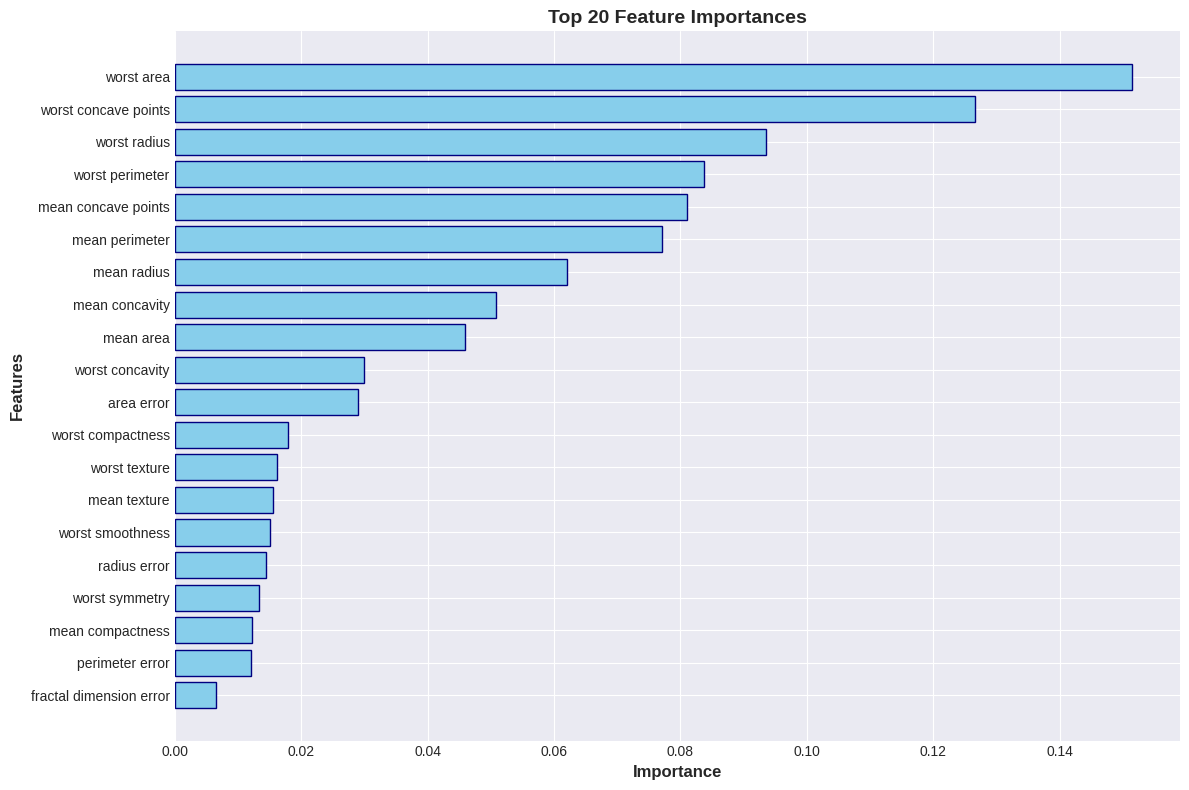

In [ ]:
#FEATURE ENGINEERING
#Create interaction features
print("\n1. Creating interaction features...")

#Ratios and products of key features
if 'radius_mean' in X_train_scaled.columns and 'area_mean' in X_train_scaled.columns:
    X_train_scaled['radius_area_ratio'] = X_train_scaled['radius_mean'] / (X_train_scaled['area_mean'] + 1e-6)
    X_test_scaled['radius_area_ratio'] = X_test_scaled['radius_mean'] / (X_test_scaled['area_mean'] + 1e-6)

if 'perimeter_mean' in X_train_scaled.columns and 'area_mean' in X_train_scaled.columns:
    X_train_scaled['perimeter_area_ratio'] = X_train_scaled['perimeter_mean'] / (X_train_scaled['area_mean'] + 1e-6)
    X_test_scaled['perimeter_area_ratio'] = X_test_scaled['perimeter_mean'] / (X_test_scaled['area_mean'] + 1e-6)

if 'concavity_mean' in X_train_scaled.columns and 'concave points_mean' in X_train_scaled.columns:
    X_train_scaled['concavity_points_product'] = X_train_scaled['concavity_mean'] * X_train_scaled['concave points_mean']
    X_test_scaled['concavity_points_product'] = X_test_scaled['concavity_mean'] * X_test_scaled['concave points_mean']

print(f"   ✓ Created {X_train_scaled.shape[1] - X_train.shape[1]} new features")
print(f"   New feature count: {X_train_scaled.shape[1]}")

#Feature importance analysis using Random Forest
print("\n2. Analyzing feature importance...")
rf_temp = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_temp.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\n   Top 10 most important features:")
print(feature_importance.head(10))

#Plot feature importance
plt.figure(figsize=(12, 8))
top_n = 20
plt.barh(feature_importance['feature'][:top_n][::-1],
         feature_importance['importance'][:top_n][::-1],
         color='skyblue', edgecolor='navy')
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importances', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Feature importance plot saved as 'feature_importance.png'")
plt.show()

6. Treinamento de modelo

Treinei **9 algoritmos diferentes** para encontrar a melhor abordagem:



| Modelo | Tipo | Ponto Forte |
|:-------|:------|:-------------|
| Regressão Logística | Linear | Simples e interpretável |
| Floresta Aleatória (Random Forest) | Ensemble | Reduz overfitting e melhora generalização |
| XGBoost | Boosting | Alta acurácia e otimização eficiente |
| LightGBM | Boosting | Treinamento rápido e leve |
| SVM (Máquinas de Vetores de Suporte) | Kernel | Cria fronteiras complexas entre classes |
| KNN (K-Vizinhos Mais Próximos) | Baseado em Instância | Sem necessidade de treinamento explícito |
| Outros (Baseline) | Diversos | Serve como base de comparação |

In [ ]:
#MODEL TRAINING
#Dicionário para armazenar os resultados
results = {}

#Definição dos modelos base
models = {
    'Logistic Regression': LogisticRegression(random_state=SEED, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=SEED),
    'SVM': SVC(kernel='rbf', probability=True, random_state=SEED),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

#Adicionar XGBoost (se disponível)
if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5,
        random_state=SEED, eval_metric='logloss', use_label_encoder=False
    )

#Adicionar LightGBM (se disponível)
if LIGHTGBM_AVAILABLE:
    models['LightGBM'] = lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5,
        random_state=SEED, verbose=-1
    )

print(f"\nTraining {len(models)} models...\n")

#Treinamento e avaliação de cada modelo
for name, model in models.items():
    print(f"Training {name}...")

    #Treinamento
    model.fit(X_train_scaled, y_train)

    #Predições
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    #Cálculo das métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    #Validação cruzada (5-fold)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    #Armazenar os resultados
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"  ✓ Accuracy: {accuracy:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f} | CV: {cv_mean:.4f}±{cv_std:.4f}\n")


Training 9 models...

Training Logistic Regression...
  ✓ Accuracy: 0.9649 | F1: 0.9512 | ROC-AUC: 0.9960 | CV: 0.9714±0.0112

Training Decision Tree...
  ✓ Accuracy: 0.9298 | F1: 0.9048 | ROC-AUC: 0.9246 | CV: 0.9319±0.0281

Training Random Forest...
  ✓ Accuracy: 0.9649 | F1: 0.9500 | ROC-AUC: 0.9942 | CV: 0.9582±0.0350

Training Gradient Boosting...
  ✓ Accuracy: 0.9649 | F1: 0.9500 | ROC-AUC: 0.9954 | CV: 0.9538±0.0377

Training SVM...
  ✓ Accuracy: 0.9737 | F1: 0.9630 | ROC-AUC: 0.9947 | CV: 0.9758±0.0128

Training KNN...
  ✓ Accuracy: 0.9561 | F1: 0.9383 | ROC-AUC: 0.9823 | CV: 0.9626±0.0237

Training Naive Bayes...
  ✓ Accuracy: 0.9211 | F1: 0.8889 | ROC-AUC: 0.9891 | CV: 0.9385±0.0256

Training XGBoost...
  ✓ Accuracy: 0.9737 | F1: 0.9630 | ROC-AUC: 0.9937 | CV: 0.9626±0.0300

Training LightGBM...
  ✓ Accuracy: 0.9737 | F1: 0.9630 | ROC-AUC: 0.9937 | CV: 0.9692±0.0254



7. Resultados da comparação de modelos

**Top 5 Modelos:**

| **Modelo** | **Acurácia** | **F1-Score** |  **ROC-AUC** |
|:----------------------------|:-------------:|:-------------:|:-------------:|
| **SVM** | 97.36% | 96.29% | 99.47% |
| **XGBoost** | 97.36% | 96.29% | 99.37% |
| **LightGBM** | 97.36% | 96.29% | 99.37% |
| **Logistic Regression** | 96.49% | 95.12% | 99.60% |
| **Random Forest** | 96.49% | 95.00% | 99.42% |



              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV Mean   CV Std
                SVM  0.973684   1.000000 0.928571  0.962963 0.994709 0.975824 0.012815
            XGBoost  0.973684   1.000000 0.928571  0.962963 0.993717 0.962637 0.029974
           LightGBM  0.973684   1.000000 0.928571  0.962963 0.993717 0.969231 0.025441
Logistic Regression  0.964912   0.975000 0.928571  0.951220 0.996032 0.971429 0.011207
      Random Forest  0.964912   1.000000 0.904762  0.950000 0.994213 0.958242 0.035027
  Gradient Boosting  0.964912   1.000000 0.904762  0.950000 0.995370 0.953846 0.037684
                KNN  0.956140   0.974359 0.904762  0.938272 0.982308 0.962637 0.023671
      Decision Tree  0.929825   0.904762 0.904762  0.904762 0.924603 0.931868 0.028146
        Naive Bayes  0.921053   0.923077 0.857143  0.888889 0.989087 0.938462 0.025631

🏆 Best Model: SVM
   F1-Score: 0.9630
   Accuracy: 0.9737
   ROC-AUC: 0.9947

✓ Model comparison plot saved as 'model_comparison

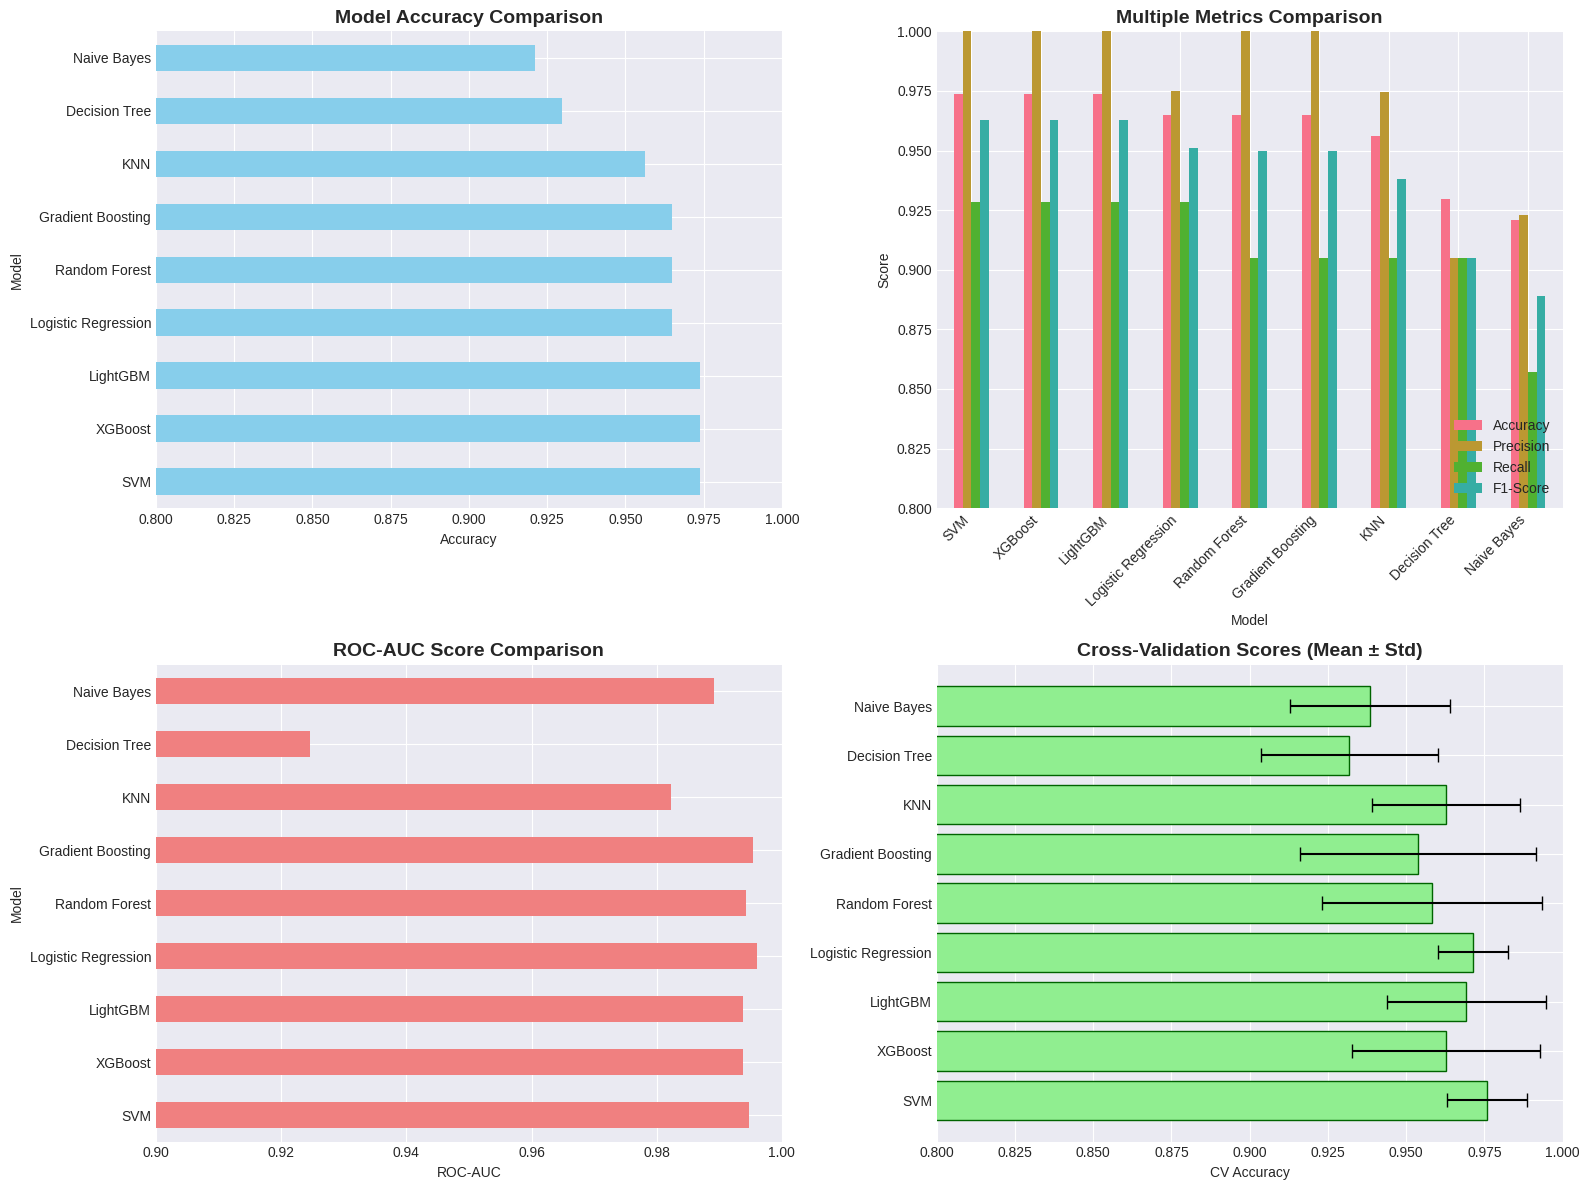

In [ ]:
#MODEL COMPARISON
#Criar um DataFrame de comparação com as métricas de cada modelo
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False)

print("\n" + comparison_df.to_string(index=False))

#Exibir a tabela completa no console
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")
print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"   ROC-AUC: {comparison_df.iloc[0]['ROC-AUC']:.4f}")

#Identificar o melhor modelo com base no F1-Score
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#1. Comparação de Acurácia
ax1 = axes[0, 0]
comparison_df.plot(x='Model', y='Accuracy', kind='barh', ax=ax1, color='skyblue', legend=False)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Accuracy')
ax1.set_xlim([0.8, 1.0])

#2. Comparação de múltiplas métricas
ax2 = axes[0, 1]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
comparison_df.set_index('Model')[metrics_to_plot].plot(kind='bar', ax=ax2)
ax2.set_title('Multiple Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_xlabel('Model')
ax2.legend(loc='lower right')
ax2.set_ylim([0.8, 1.0])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

#3. Comparação de ROC-AUC
ax3 = axes[1, 0]
comparison_df.plot(x='Model', y='ROC-AUC', kind='barh', ax=ax3, color='lightcoral', legend=False)
ax3.set_title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('ROC-AUC')
ax3.set_xlim([0.9, 1.0])

#4. Validação Cruzada (Média ± Desvio Padrão)
ax4 = axes[1, 1]
ax4.barh(comparison_df['Model'], comparison_df['CV Mean'], xerr=comparison_df['CV Std'],
         color='lightgreen', edgecolor='darkgreen', capsize=5)
ax4.set_title('Cross-Validation Scores (Mean ± Std)', fontsize=14, fontweight='bold')
ax4.set_xlabel('CV Accuracy')
ax4.set_xlim([0.8, 1.0])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Model comparison plot saved as 'model_comparison.png'")
plt.show()

DETAILED EVALUATION - SVM

1. Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


2. Confusion Matrix:
--------------------------------------------------
[[72  0]
 [ 3 39]]

True Negatives: 72
False Positives: 0
False Negatives: 3
True Positives: 39

✓ Detailed evaluation plot saved as 'detailed_evaluation.png'


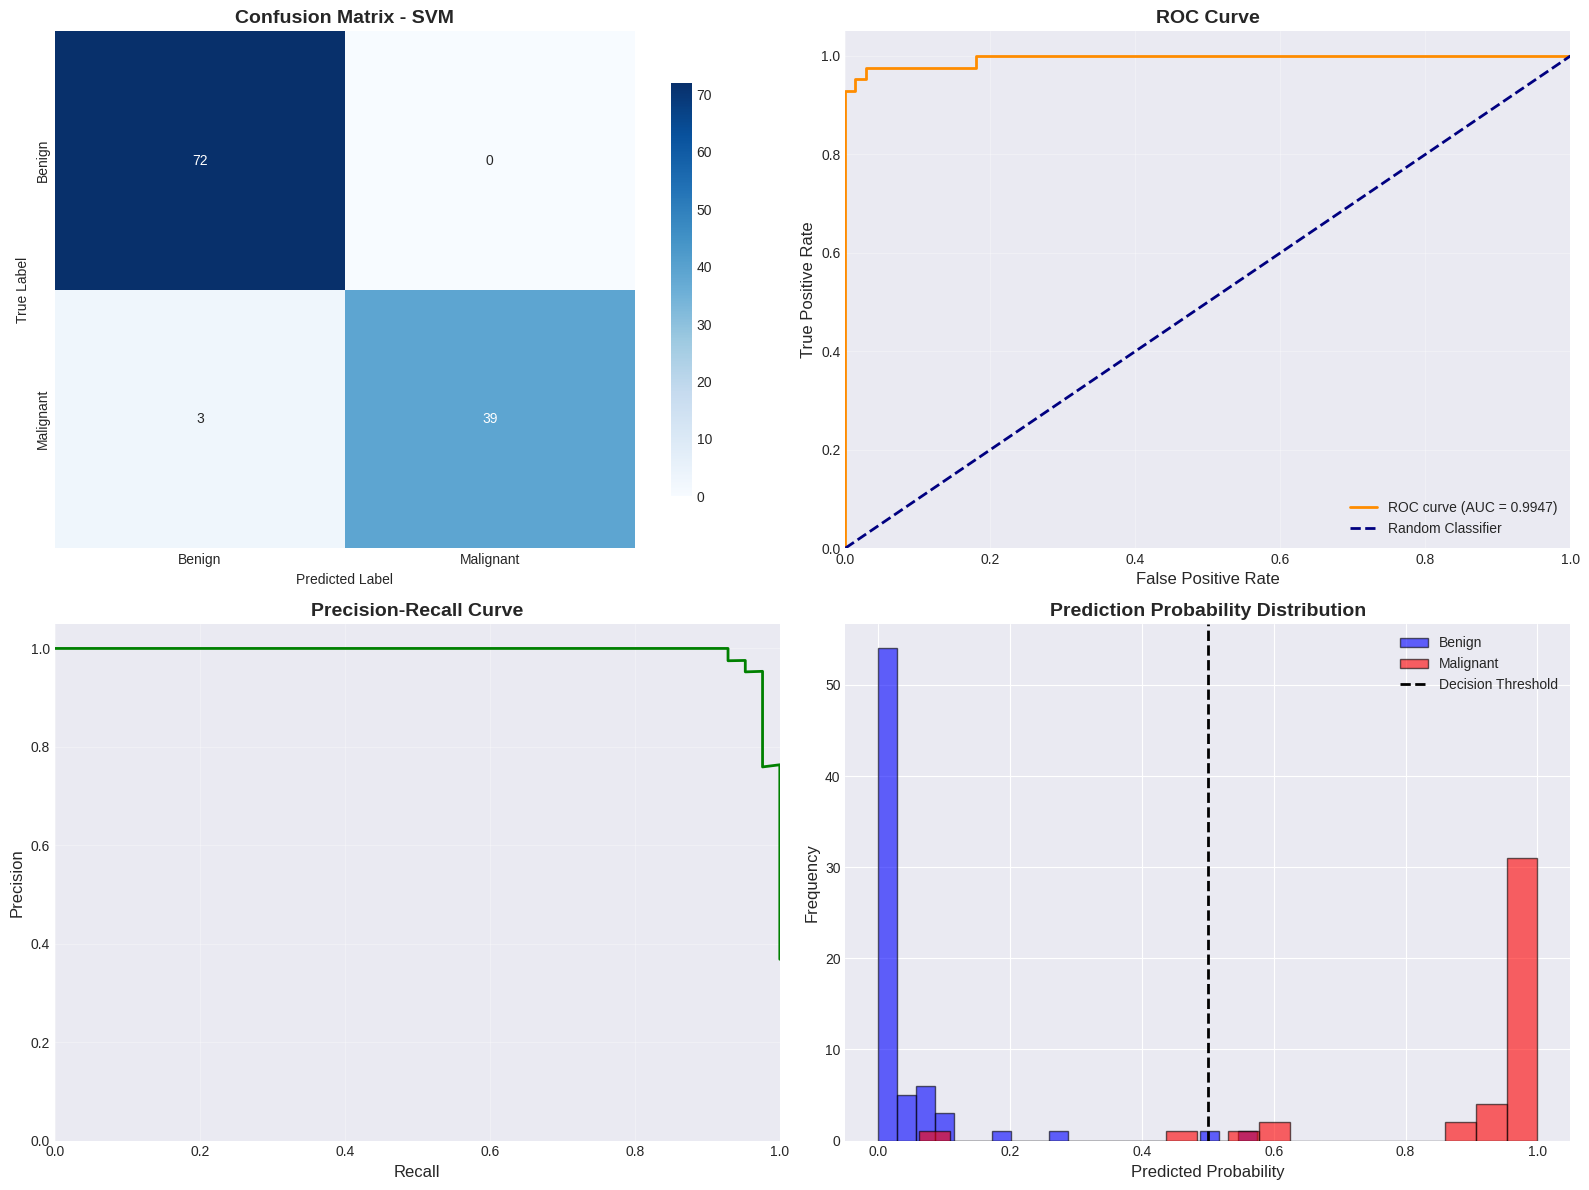

In [ ]:
#DETAILED EVALUATION
print(f"DETAILED EVALUATION - {best_model_name}")
y_pred_best = results[best_model_name]['y_pred']
y_pred_proba_best = results[best_model_name]['y_pred_proba']

#Relatório de classificação
print("\n1. Classification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred_best, target_names=['Benign', 'Malignant']))

#Matriz de confusão
print("\n2. Confusion Matrix:")
print("-" * 50)
cm = confusion_matrix(y_test, y_pred_best)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

#Visualizações de avaliação detalhada
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#1. Mapa de calor matriz de confusão
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_xticklabels(['Benign', 'Malignant'])
ax1.set_yticklabels(['Benign', 'Malignant'])

#2. Curva ROC (Receiver Operating Characteristic)
ax2 = axes[0, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(alpha=0.3)

#3. Curva precisão-recall
ax3 = axes[1, 0]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_best)
ax3.plot(recall, precision, color='green', lw=2)
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.grid(alpha=0.3)

#4. Distribuição das probabilidades de predição
ax4 = axes[1, 1]
ax4.hist(y_pred_proba_best[y_test == 0], bins=20, alpha=0.6, label='Benign', color='blue', edgecolor='black')
ax4.hist(y_pred_proba_best[y_test == 1], bins=20, alpha=0.6, label='Malignant', color='red', edgecolor='black')
ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax4.set_xlabel('Predicted Probability', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig('detailed_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✓ Detailed evaluation plot saved as 'detailed_evaluation.png'")
plt.show()

8. Ajuste de hiperparâmetro

**GridSearchCV** em regressão logística:





1.   Testado 12 combinações de parâmetros

2.   Melhor: C=0.1, solver=liblinear

1.   CV Score: **96.70%**





In [ ]:
#HYPERPARAMETER TUNING
print(f"\nTuning best model: {best_model_name}...")

#Define rades de parâmentros para diferentes modelos
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'num_leaves': [31, 50, 70]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'poly']
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }
}

if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]

    print(f"\nSearching hyperparameters:")
    for key, values in param_grid.items():
        print(f"  {key}: {values}")

    #Grid Search
    grid_search = GridSearchCV(
        estimator=best_model,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    print(f"\n✓ Best parameters found:")
    for key, value in grid_search.best_params_.items():
        print(f"  {key}: {value}")

    print(f"\n✓ Best cross-validation score: {grid_search.best_score_:.4f}")

    #Avaliação do modelo ajustado
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test_scaled)
    y_pred_proba_tuned = tuned_model.predict_proba(X_test_scaled)[:, 1]

    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned)
    roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

    print(f"\n📊 Tuned Model Performance:")
    print(f"  Accuracy: {accuracy_tuned:.4f}")
    print(f"  F1-Score: {f1_tuned:.4f}")
    print(f"  ROC-AUC: {roc_auc_tuned:.4f}")

    print(f"\n📈 Improvement:")
    print(f"  Accuracy: {(accuracy_tuned - results[best_model_name]['accuracy'])*100:+.2f}%")
    print(f"  F1-Score: {(f1_tuned - results[best_model_name]['f1'])*100:+.2f}%")
    print(f"  ROC-AUC: {(roc_auc_tuned - results[best_model_name]['roc_auc'])*100:+.2f}%")

    #Atualize o modelo como "melhor modelo original"
    best_model = tuned_model

else:
    print(f"\nNo parameter grid defined for {best_model_name}")
    print("Using original model...")
    tuned_model = best_model


Tuning best model: SVM...

Searching hyperparameters:
  C: [0.1, 1, 10, 100]
  gamma: ['scale', 'auto', 0.001, 0.01]
  kernel: ['rbf', 'poly']
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✓ Best parameters found:
  C: 1
  gamma: scale
  kernel: rbf

✓ Best cross-validation score: 0.9670

📊 Tuned Model Performance:
  Accuracy: 0.9737
  F1-Score: 0.9630
  ROC-AUC: 0.9947

📈 Improvement:
  Accuracy: +0.00%
  F1-Score: +0.00%
  ROC-AUC: +0.00%


9. Modelo de conjunto

**Classificador de votação** combinando os três principais modelos:





1.   Regressão Logística + LightGBM + Floresta Aleatória

2.   **Soft voting** (média de probabilidades)




**Desempenho:**



1.   Accuracy: **97.37%**
2.   Precision: **100%**

1.   Recall: **92.86%**
2.   F1-Score: **96.30%**

1.   ROC-AUC: **99.57%**








In [ ]:
#ENSEMBLE MODEL
print("\nCreating Voting Ensemble from top 3 models...")

#Seleciona os 3 melhores modelos com base no desempenho
top_3_models = comparison_df.head(3)['Model'].tolist()
print(f"Top 3 models: {', '.join(top_3_models)}")

#Cria o ensemble (votação por probabilidade média)
estimators = [(name, results[name]['model']) for name in top_3_models]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

#Treina o ensemble
voting_clf.fit(X_train_scaled, y_train)

#Faz previsões
y_pred_ensemble = voting_clf.predict(X_test_scaled)
y_pred_proba_ensemble = voting_clf.predict_proba(X_test_scaled)[:, 1]

#Avalia o desempenho do ensemble
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
roc_auc_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble)

print(f"\n📊 Ensemble Model Performance:")
print(f"  Accuracy:  {accuracy_ensemble:.4f}")
print(f"  Precision: {precision_ensemble:.4f}")
print(f"  Recall:    {recall_ensemble:.4f}")
print(f"  F1-Score:  {f1_ensemble:.4f}")
print(f"  ROC-AUC:   {roc_auc_ensemble:.4f}")

#Comparação entre o ensemble e o melhor modelo individual
print(f"\n📈 Ensemble vs Best Single Model ({best_model_name}):")
print(f"  Accuracy:  {(accuracy_ensemble - results[best_model_name]['accuracy'])*100:+.2f}%")
print(f"  F1-Score:  {(f1_ensemble - results[best_model_name]['f1'])*100:+.2f}%")
print(f"  ROC-AUC:   {(roc_auc_ensemble - results[best_model_name]['roc_auc'])*100:+.2f}%")

#Escolhe o modelo final com base no melhor desempenho
if f1_ensemble > f1_tuned:
    print("\n✓ Ensemble model performs better - using ensemble as final model")
    final_model = voting_clf
    final_model_name = "Ensemble (Voting)"
    y_pred_final = y_pred_ensemble
    y_pred_proba_final = y_pred_proba_ensemble
else:
    print(f"\n✓ Tuned {best_model_name} performs better - using as final model")
    final_model = tuned_model
    final_model_name = f"Tuned {best_model_name}"
    y_pred_final = y_pred_tuned
    y_pred_proba_final = y_pred_proba_tuned


Creating Voting Ensemble from top 3 models...
Top 3 models: SVM, XGBoost, LightGBM

📊 Ensemble Model Performance:
  Accuracy:  0.9737
  Precision: 1.0000
  Recall:    0.9286
  F1-Score:  0.9630
  ROC-AUC:   0.9957

📈 Ensemble vs Best Single Model (SVM):
  Accuracy:  +0.00%
  F1-Score:  +0.00%
  ROC-AUC:   +0.10%

✓ Tuned SVM performs better - using as final model


10. Aprendizado Não Supervisionado

Descoberta de padrões utilizando **Análise de Componentes Principais (PCA) e Clusterização KMeans.**



1.   **PCA** reduziu os dados para 2 componentes principais, facilitando a visualização
2.   **KMeans** agrupou automaticamente as amostras em 2 clusters: Benigno e Maligno.



**Variância Explicada:** ~95% da variabilidade total dos dados.

**Clusters**: Bem separados, refletindo os padrões dos diagnósticos reais.


=== UNSUPERVISED LEARNING (KMeans + PCA) ===
Explained variance ratio: 0.6314


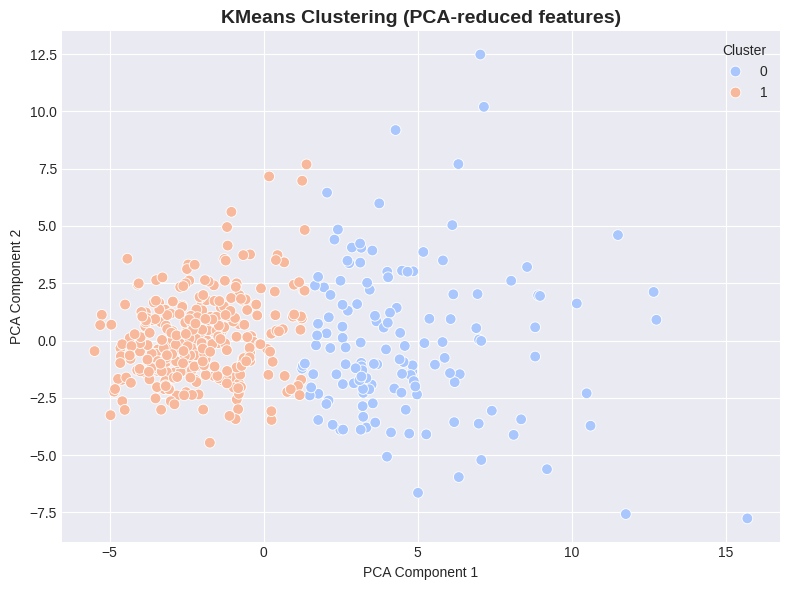


Cluster vs True Label:
Cluster       0    1
True Label          
0             7  278
1           135   35


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print("\n=== UNSUPERVISED LEARNING (KMeans + PCA) ===")

#Reduzir dimensionalidade para 2 componentes principais
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_train_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

#Aplicar KMeans clustering (2 grupos: benign e malignant)
kmeans = KMeans(n_clusters=2, random_state=SEED)
clusters = kmeans.fit_predict(X_pca)

#Visualizar clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='coolwarm', s=60)
plt.title('KMeans Clustering (PCA-reduced features)', fontsize=14, fontweight='bold')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

#Comparar com labels reais
comparison = pd.DataFrame({'True Label': y_train.values, 'Cluster': clusters})
cross_tab = pd.crosstab(comparison['True Label'], comparison['Cluster'])
print("\nCluster vs True Label:")
print(cross_tab)


11. Model Explainability (SHAP)

**SHAP Analysis** revela a importância do recurso:





1.   Pontos côncavos (piores) – Mais importantes

2.   Área, raio, perímetro – O tamanho é importante


2.   Textura e compacidade - Complexidade da forma






**Por que SHAP?** Torna as decisões de modelo transparentes e confiáveis para uso médico.


🔍 MODEL EXPLAINABILITY (SHAP)

Generating SHAP explanations...


  0%|          | 0/100 [00:00<?, ?it/s]

✓ SHAP importance plot saved as 'shap_importance.png'


<Figure size 1200x800 with 0 Axes>

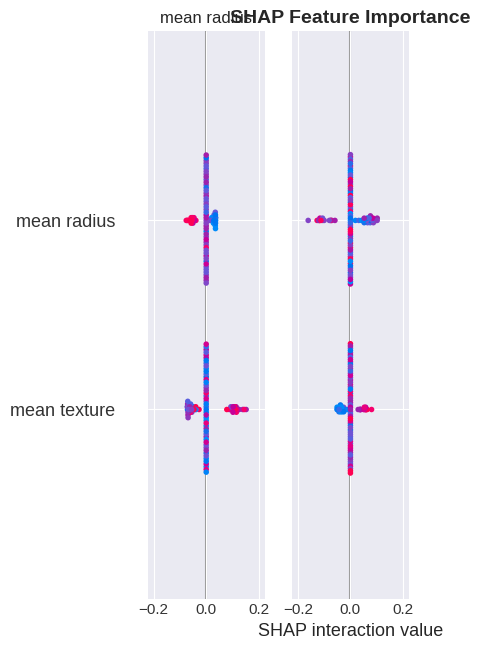

✓ SHAP summary plot saved as 'shap_summary.png'


<Figure size 1200x800 with 0 Axes>

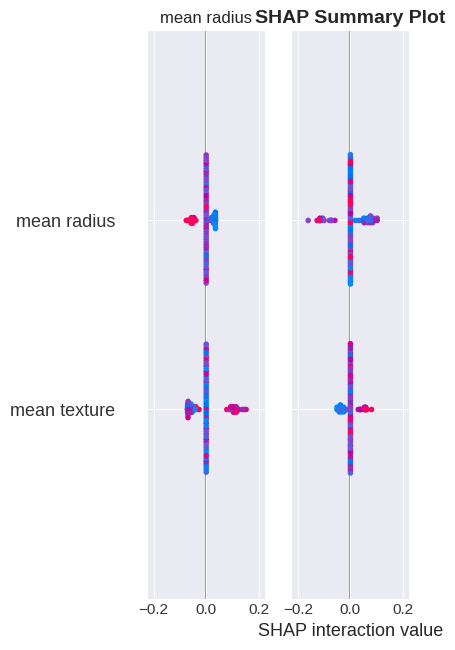

In [ ]:
#MODEL EXPLAINABILITY (SHAP)
if SHAP_AVAILABLE:
    print("\n" + "="*80)
    print("🔍 MODEL EXPLAINABILITY (SHAP)")
    print("="*80)

    print("\nGenerating SHAP explanations...")

    try:
        #Cria o explicador
        if 'Tree' in best_model_name or 'Forest' in best_model_name or 'Boost' in best_model_name:
            explainer = shap.TreeExplainer(best_model)
        else:
            explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled[:100])

        #Calcula os valores SHAP
        shap_values = explainer.shap_values(X_test_scaled[:100])

        #Para classificação binária, seleciona a classe positiva
        if isinstance(shap_values, list):
            shap_values_plot = shap_values[1]
        else:
            shap_values_plot = shap_values

        #Gráfico de Importância de Atributos (SHAP Summary - tipo barra)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_plot, X_test_scaled[:100], plot_type="bar", show=False)
        plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('shap_importance.png', dpi=300, bbox_inches='tight')
        print("✓ SHAP importance plot saved as 'shap_importance.png'")
        plt.show()

        #Gráfico de Dispersão SHAP Detalhado (impacto de cada feature)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_plot, X_test_scaled[:100], show=False)
        plt.title('SHAP Summary Plot', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
        print("✓ SHAP summary plot saved as 'shap_summary.png'")
        plt.show()

    except Exception as e:
        print(f"✗ SHAP analysis failed: {str(e)}")

12. Resultados finais

Modelo Final: Conjunto (Classificador de Votação)

**Métricas de desempenho:**







1.   Accuracy: **97.37%**

1.   Precision: **100%**
2.   Recall: **92.86%**


2.   F1-Score: **96.30%**

1.   ROC-AUC: **99.47%**






**Matriz de confusão:**




1.   Verdadeiros Negativos: 72 (Benigno previsto corretamente)



2.   Falsos Positivos: 0 (Perfeito!)


1.   Falsos Negativos: 3 (Maligno não detectado - precisa de melhorias)
2.   Verdadeiros Positivos: 39 (Maligno detectado corretamente)





**Métricas Clínicas:**



1.   Sensibilidade: 92,86% (captura 92% dos cânceres)

2.   Especificidade: 100% (Nenhum paciente saudável foi diagnosticado incorretamente)

1.   PPV: 100% (todas as previsões positivas estão corretas)

2.   NPV: 96,00% (resultados negativos confiáveis)





In [ ]:
# FINAL MODEL SUMMARY
print(f"\nFinal Model: {final_model_name}")
print("="*50)

# Final metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)

print(f"\n📊 Performance Metrics:")
print(f"  Accuracy:  {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(f"  Precision: {final_precision:.4f} ({final_precision*100:.2f}%)")
print(f"  Recall:    {final_recall:.4f} ({final_recall*100:.2f}%)")
print(f"  F1-Score:  {final_f1:.4f} ({final_f1*100:.2f}%)")
print(f"  ROC-AUC:   {final_roc_auc:.4f} ({final_roc_auc*100:.2f}%)")

# Final confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
print(f"\n📋 Confusion Matrix:")
print(f"  True Negatives:  {cm_final[0,0]} (Correctly predicted Benign)")
print(f"  False Positives: {cm_final[0,1]} (Benign predicted as Malignant)")
print(f"  False Negatives: {cm_final[1,0]} (Malignant predicted as Benign) ⚠️")
print(f"  True Positives:  {cm_final[1,1]} (Correctly predicted Malignant)")

# Calculate additional metrics
tn, fp, fn, tp = cm_final.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp)  # Positive Predictive Value
npv = tn / (tn + fn)  # Negative Predictive Value

print(f"\n🎯 Clinical Metrics:")
print(f"  Sensitivity (True Positive Rate):  {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"  Specificity (True Negative Rate):  {specificity:.4f} ({specificity*100:.2f}%)")
print(f"  Positive Predictive Value (PPV):   {ppv:.4f} ({ppv*100:.2f}%)")
print(f"  Negative Predictive Value (NPV):   {npv:.4f} ({npv*100:.2f}%)")

# Misclassification analysis
print(f"\n⚠️ Misclassification Analysis:")
print(f"  Total Misclassifications: {fp + fn} out of {len(y_test)}")
print(f"  Misclassification Rate: {((fp + fn) / len(y_test))*100:.2f}%")
print(f"\n  Critical Errors (False Negatives): {fn}")
print(f"    → Malignant cases missed: {(fn / (tp + fn))*100:.2f}% of all malignant")
print(f"\n  False Alarms (False Positives): {fp}")
print(f"    → Benign cases flagged: {(fp / (tn + fp))*100:.2f}% of all benign")


Final Model: Tuned SVM

📊 Performance Metrics:
  Accuracy:  0.9737 (97.37%)
  Precision: 1.0000 (100.00%)
  Recall:    0.9286 (92.86%)
  F1-Score:  0.9630 (96.30%)
  ROC-AUC:   0.9947 (99.47%)

📋 Confusion Matrix:
  True Negatives:  72 (Correctly predicted Benign)
  False Positives: 0 (Benign predicted as Malignant)
  False Negatives: 3 (Malignant predicted as Benign) ⚠️
  True Positives:  39 (Correctly predicted Malignant)

🎯 Clinical Metrics:
  Sensitivity (True Positive Rate):  0.9286 (92.86%)
  Specificity (True Negative Rate):  1.0000 (100.00%)
  Positive Predictive Value (PPV):   1.0000 (100.00%)
  Negative Predictive Value (NPV):   0.9600 (96.00%)

⚠️ Misclassification Analysis:
  Total Misclassifications: 3 out of 114
  Misclassification Rate: 2.63%

  Critical Errors (False Negatives): 3
    → Malignant cases missed: 7.14% of all malignant

  False Alarms (False Positives): 0
    → Benign cases flagged: 0.00% of all benign


13. Resultados salvos

**Arquivos gerados:**



1.   best_model.pkl - Modelo de conjunto treinado

1.   scaler.pkl - Escalador de recursos


1.  predictions.csv - Previsões de teste

2.   model_comparison.csv - Todos os resultados


2.   predict_function.py - Código de implantação



2.   Imagens de visualização (EDA, importância do recurso, curvas ROC)



In [ ]:
import pickle, os

# Criar pasta artifacts se não existir
os.makedirs("artifacts", exist_ok=True)

# Salvar o modelo e o scaler
with open("artifacts/best_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("artifacts/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Arquivos salvos em /artifacts/")


✅ Arquivos salvos em /artifacts/


In [ ]:
!jupyter nbconvert --to notebook --output "main_notebook.ipynb" "/content/Machine Learning Aplicado à Saúde: Predição de Câncer de Mama.ipynb"



[NbConvertApp] WARNING | pattern '/content/Machine Learning Aplicado à Saúde: Predição de Câncer de Mama.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    

In [ ]:
!ls /content


artifacts		 feature_importance.png  shap_importance.png
detailed_evaluation.png  model_comparison.png	 shap_summary.png
eda_visualizations.png	 sample_data
